# Downsample

In [2]:
import utils

## 1. Load data

In [2]:
!gsutil -m cp -n -r gs://capstone_datasets/librispeech/test/predictions/* ./predictions/

Copying gs://capstone_datasets/librispeech/test/predictions/lr-clean-test-w2v2-base-960h.hf/dataset.arrow...
Copying gs://capstone_datasets/librispeech/test/predictions/lr-clean-test-w2v2-base-960h.hf/dataset_info.json...
Copying gs://capstone_datasets/librispeech/test/predictions/lr-clean-test-w2v2-base-960h.hf/state.json...
/ [3/3 files][717.1 MiB/717.1 MiB] 100% Done  59.1 MiB/s ETA 00:00:00           
Operation completed over 3 objects/717.1 MiB.                                    


In [3]:
dataset = utils.load_from_disk(utils.os.path.join(utils.predictions_path, 'lr-clean-test-w2v2-base-960h.hf'))

In [4]:
dataset

Dataset({
    features: ['audio', 'label', 'ground_truth', 'logits', 'transcription'],
    num_rows: 2620
})

In [5]:
dataset.num_rows

2620

## 2. Select 200 audio tracks randomly

In [6]:
import random

# set seed
random.seed(69)

# select rows of dataset to form a 'tiny' one
num_tracks = 200
tiny_dataset = dataset.select(random.sample(range(dataset.num_rows), num_tracks))

## 3. Load tokenizer and model (base-960h)

In [7]:
tokenizer, model = utils.load_wav2vec_model("facebook/wav2vec2-base-960h")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/opt/conda/lib/python3.7/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:757: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  FutureWarning,
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4. Downsample across range of rates and compute respective prediction and WER

In [8]:
ds_rates = [16000,8000,4000,2000,1000,500]
wers = [utils.wer(tiny_dataset["ground_truth"], tiny_dataset["transcription"])]

In [9]:
wers

[0.03019627579265224]

In [10]:
for idx in range(len(ds_rates)-1):
    print(10 * '-')
    print('downsampling to ' + str(ds_rates[idx+1]) + ' Hz...')
    tiny_dataset_ds = tiny_dataset.map(utils.map_to_downsampled, fn_kwargs={"input_sr": 16000, "output_sr": ds_rates[idx+1]})
    print('computing prediction...')
    tiny_dataset_ds_preds = tiny_dataset_ds.map(utils.map_to_pred, fn_kwargs={"model": model, "tokenizer": tokenizer})
    wer = utils.wer(tiny_dataset_ds_preds["ground_truth"], tiny_dataset_ds_preds["transcription"])
    print('wer=', round(100 * wer, 1), '%.')
    wers.append(wer)

----------
downsampling to 8000 Hz...


  0%|          | 0/200 [00:00<?, ?ex/s]

computing prediction...


  0%|          | 0/200 [00:00<?, ?ex/s]

wer= 3.8 %.
----------
downsampling to 4000 Hz...


  0%|          | 0/200 [00:00<?, ?ex/s]

computing prediction...


  0%|          | 0/200 [00:00<?, ?ex/s]

wer= 19.8 %.
----------
downsampling to 2000 Hz...


  0%|          | 0/200 [00:00<?, ?ex/s]

computing prediction...


  0%|          | 0/200 [00:00<?, ?ex/s]

wer= 84.9 %.
----------
downsampling to 1000 Hz...


  0%|          | 0/200 [00:00<?, ?ex/s]

computing prediction...


  0%|          | 0/200 [00:00<?, ?ex/s]

wer= 99.2 %.
----------
downsampling to 500 Hz...


  0%|          | 0/200 [00:00<?, ?ex/s]

computing prediction...


  0%|          | 0/200 [00:00<?, ?ex/s]

wer= 100.0 %.


In [11]:
print(wers)

[0.03019627579265224, 0.03799698037242073, 0.19828887770508305, 0.8490186210367388, 0.9921992954202316, 1.0]


## 5. Plot WERS

In [6]:
ds_rates = [16000,8000,4000,2000,1000,500]
wers = [0.03019627579265224, 0.03799698037242073, 0.19828887770508305, 0.8490186210367388, 0.9921992954202316, 1.0]

In [7]:
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


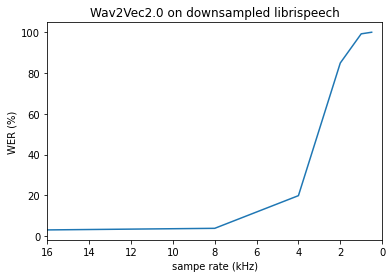

In [10]:
# set figure
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(ds_rates, [100 * wer for wer in wers])
ax.set_xlim(0,16000)
fig.canvas.draw()

# set new tick labels
labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [str(int(int(label) / 1000)) for label in labels]
ax.set_xticklabels(new_labels)

# plot
plt.xlabel("sampe rate (kHz)")
plt.ylabel("WER (%)")
ax.invert_xaxis()
plt.title("Wav2Vec2.0 on downsampled librispeech")
plt.show()